In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Set random seed for reproducibility
np.random.seed(42)

In [8]:
data = pd.read_csv("covidcast_new-1.csv")
data.head()

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,1/7/2021,1000,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,29.288429,30.487852,57.334785,3.244379,2.6382,28.469582,18.571266,9.482316,24.962112,84.311759,12.627098
1,1/7/2021,1003,32.814153,10.189340,1.270183,61.516584,25.179399,51.160278,NaN,28.384842,53.172285,1.199572,NaN,27.532881,23.406516,8.933682,28.864558,82.778220,11.727249
2,1/7/2021,1015,35.621311,14.591271,6.594649,NaN,NaN,54.503711,NaN,37.003522,NaN,3.890709,NaN,NaN,20.974363,NaN,NaN,NaN,13.255336
3,1/7/2021,1051,40.453615,14.164503,3.320922,68.718538,19.438763,54.948755,NaN,37.637900,67.550815,3.284647,NaN,30.223647,20.009477,7.570250,26.494057,86.587182,13.823318
4,1/7/2021,1069,39.228766,10.103564,0.288897,59.961036,23.065494,60.118290,NaN,36.156326,55.995745,1.881970,NaN,30.806929,16.574756,12.916249,24.747620,85.825453,10.258936


Dataset Shape: (25626, 19)

Missing values in target variables:
Vaccine uptake: 2602
COVID test positivity: 21632

Labeled data shape: (3994, 19)
Unlabeled data shape: (21632, 19)

Selected features for modeling: 14

Proxy Model Performance on Validation Set:
MSE: 13.4844
R²: 0.7722

Combined Dataset Shape: (25626, 20)
Real labels: 3994
Pseudo-labels: 21632

Final Model Performance (Overall Test Set):
MSE: 2.5318
R²: 0.9261

Final Model Performance (Real Labels Only):
MSE: 11.7486
R²: 0.8054

Top 10 Important Features:
                                 Feature  Importance
0                          smoothed_wcli    0.557229
8            smoothed_wpublic_transit_1d    0.123854
6                smoothed_wrestaurant_1d    0.075665
3                smoothed_wothers_masked    0.049627
13  smoothed_wvaccine_likely_politicians    0.035941
9           smoothed_wworried_become_ill    0.031458
7                      smoothed_wshop_1d    0.029411
5               smoothed_wlarge_event_1d    0.02239

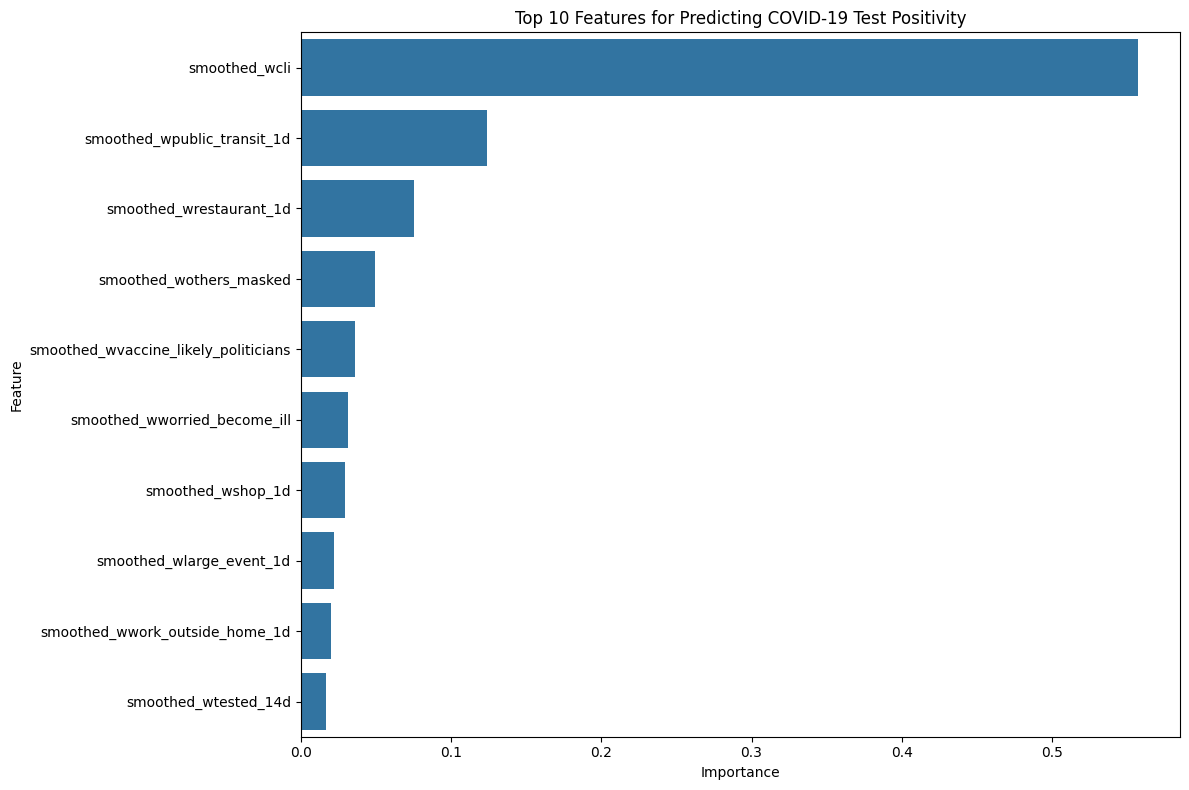

In [9]:
# Initial data exploration
print("Dataset Shape:", data.shape)

# Check missing values in our target variables
print("\nMissing values in target variables:")
print("Vaccine uptake:", data['smoothed_wcovid_vaccinated'].isna().sum())
print("COVID test positivity:", data['smoothed_wtested_positive_14d'].isna().sum())

# Let's implement semi-supervised learning for the COVID positivity rate

# Step 1: Split data into labeled and unlabeled sets
labeled_data = data.dropna(subset=['smoothed_wtested_positive_14d'])
unlabeled_data = data[data['smoothed_wtested_positive_14d'].isna()]

print(f"\nLabeled data shape: {labeled_data.shape}")
print(f"Unlabeled data shape: {unlabeled_data.shape}")

# Feature selection - exclude target variables and non-predictive features
# You may need to adjust this list based on your EDA
features = [
    'smoothed_wcli', 'smoothed_wtested_14d', 
    'smoothed_wwearing_mask', 'smoothed_wothers_masked',
    'smoothed_wwork_outside_home_1d', 'smoothed_wlarge_event_1d',
    'smoothed_wrestaurant_1d', 'smoothed_wshop_1d',
    'smoothed_wspend_time_1d', 'smoothed_wpublic_transit_1d',
    'smoothed_wworried_become_ill',
    'smoothed_wvaccine_likely_friends', 'smoothed_wvaccine_likely_who',
    'smoothed_wvaccine_likely_govt_health', 'smoothed_wvaccine_likely_politicians'
]

# Check for any missing features in our feature list
missing_features = [f for f in features if f not in data.columns]
if missing_features:
    print(f"Warning: These features are not in the dataset: {missing_features}")
    # Remove missing features from our list
    features = [f for f in features if f in data.columns]

print(f"\nSelected features for modeling: {len(features)}")

# Step 1: Train a proxy model using only labeled data
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the labeled dataset
X_labeled = labeled_data[features]
y_labeled = labeled_data['smoothed_wtested_positive_14d']

# Handle missing values in features with mean imputation
feature_imputer = SimpleImputer(strategy='mean')
X_labeled_imputed = feature_imputer.fit_transform(X_labeled)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled_imputed, y_labeled, test_size=0.2, random_state=42
)

# Train the proxy model
proxy_model = RandomForestRegressor(n_estimators=100, random_state=42)
proxy_model.fit(X_train, y_train)

# Evaluate the proxy model
y_val_pred = proxy_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"\nProxy Model Performance on Validation Set:")
print(f"MSE: {val_mse:.4f}")
print(f"R²: {val_r2:.4f}")

# Step 2: Generate pseudo-labels for unlabeled data
# Prepare the unlabeled dataset
X_unlabeled = unlabeled_data[features]
X_unlabeled_imputed = feature_imputer.transform(X_unlabeled)

# Generate pseudo-labels
pseudo_labels = proxy_model.predict(X_unlabeled_imputed)

# Create a copy of unlabeled data with pseudo-labels
unlabeled_with_pseudo = unlabeled_data.copy()
unlabeled_with_pseudo['smoothed_wtested_positive_14d'] = pseudo_labels

# Step 3: Combine labeled and pseudo-labeled data
combined_data = pd.concat([labeled_data, unlabeled_with_pseudo])

# Create a flag to identify real vs pseudo-labeled data (for evaluation)
combined_data['is_real_label'] = combined_data.index.isin(labeled_data.index)

print(f"\nCombined Dataset Shape: {combined_data.shape}")
print(f"Real labels: {combined_data['is_real_label'].sum()}")
print(f"Pseudo-labels: {combined_data.shape[0] - combined_data['is_real_label'].sum()}")

# Train the final model on combined data
X_combined = combined_data[features]
y_combined = combined_data['smoothed_wtested_positive_14d']

# Handle missing values
X_combined_imputed = feature_imputer.fit_transform(X_combined)

# Split into training and test sets, stratifying by label type
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X_combined_imputed, combined_data['is_real_label']):
    X_train_combined = X_combined_imputed[train_idx]
    y_train_combined = y_combined.iloc[train_idx]
    X_test_combined = X_combined_imputed[test_idx]
    y_test_combined = y_combined.iloc[test_idx]
    test_is_real = combined_data['is_real_label'].iloc[test_idx]

# Train the final model
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train_combined, y_train_combined)

# Evaluate on the test set (overall)
y_test_pred = final_model.predict(X_test_combined)
test_mse = mean_squared_error(y_test_combined, y_test_pred)
test_r2 = r2_score(y_test_combined, y_test_pred)

print(f"\nFinal Model Performance (Overall Test Set):")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# Separate evaluation on real vs pseudo-labeled test data
real_test_idx = test_is_real[test_is_real].index
if len(real_test_idx) > 0:
    real_test_mse = mean_squared_error(
        y_test_combined.loc[real_test_idx], 
        y_test_pred[test_is_real.values]
    )
    real_test_r2 = r2_score(
        y_test_combined.loc[real_test_idx], 
        y_test_pred[test_is_real.values]
    )
    
    print(f"\nFinal Model Performance (Real Labels Only):")
    print(f"MSE: {real_test_mse:.4f}")
    print(f"R²: {real_test_r2:.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for Predicting COVID-19 Test Positivity')
plt.tight_layout()
plt.show()

# Save the semi-supervised model's predictions back to the main dataset
data['predicted_wtested_positive_14d'] = np.nan
data.loc[unlabeled_data.index, 'predicted_wtested_positive_14d'] = pseudo_labels
data.loc[labeled_data.index, 'predicted_wtested_positive_14d'] = data.loc[labeled_data.index, 'smoothed_wtested_positive_14d']


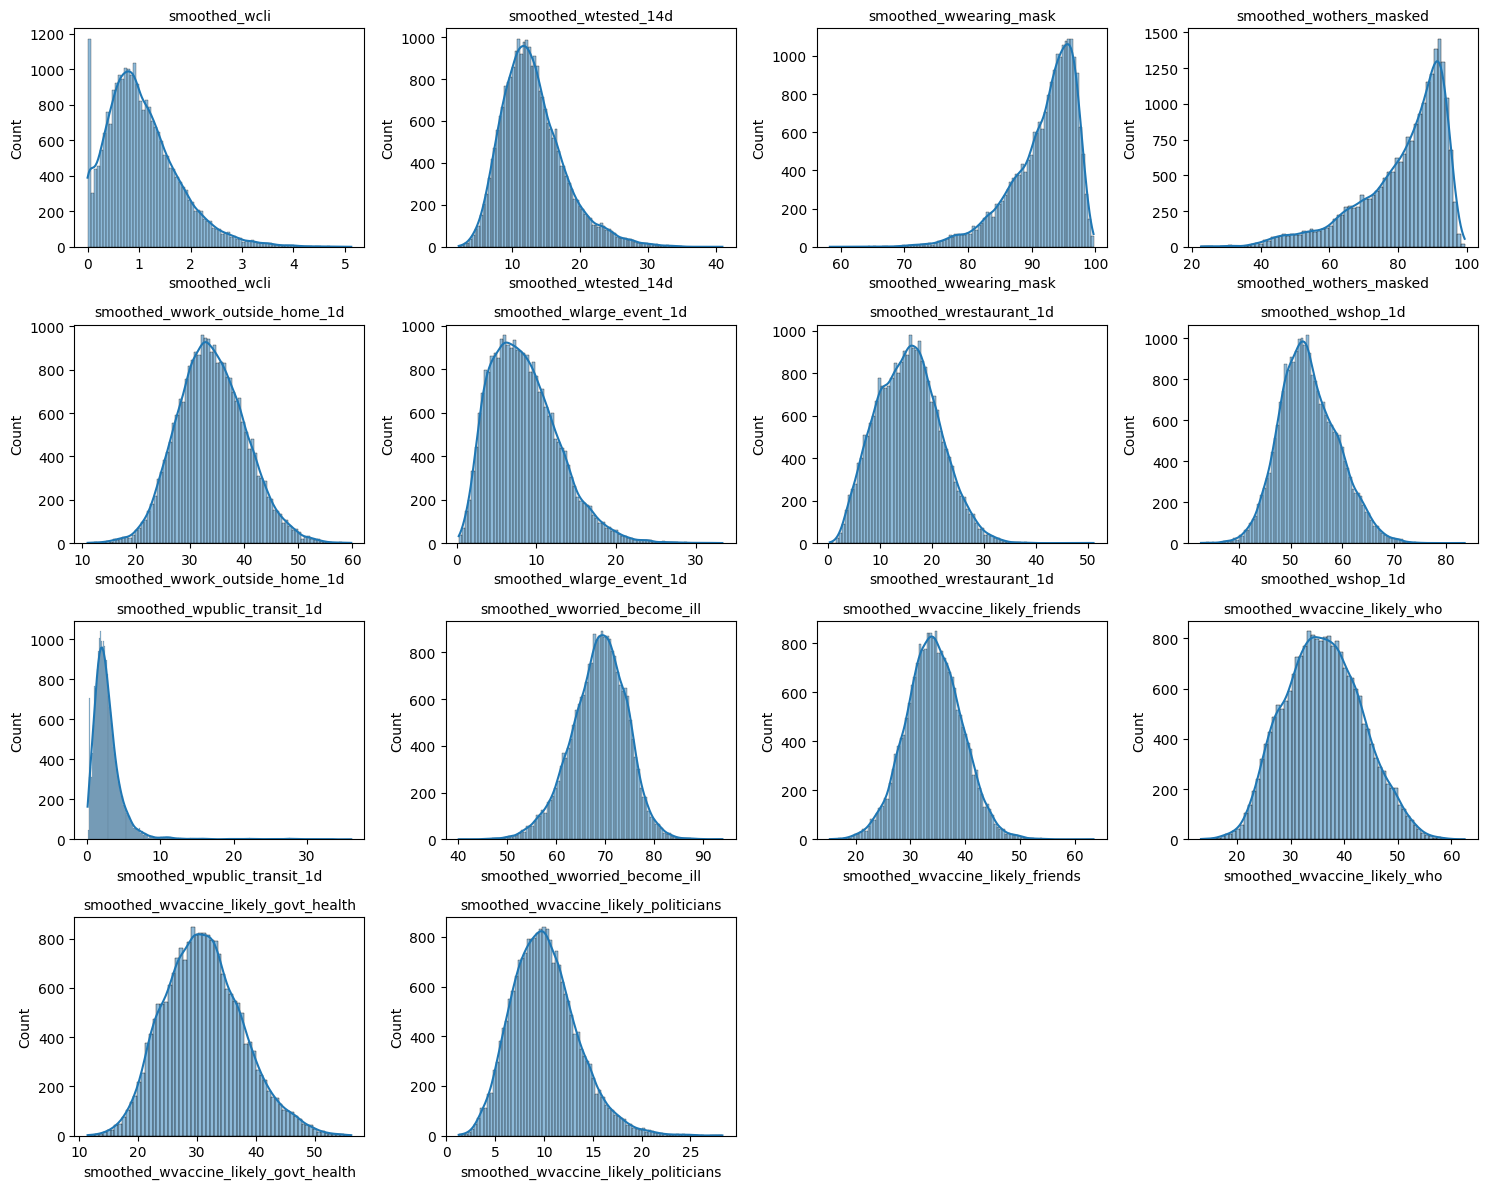

In [10]:
# 1. Additional Data Cleaning and Preparation
# Check for outliers and visualize distributions of all features
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(feature, fontsize=10)
    plt.tight_layout()
plt.show()

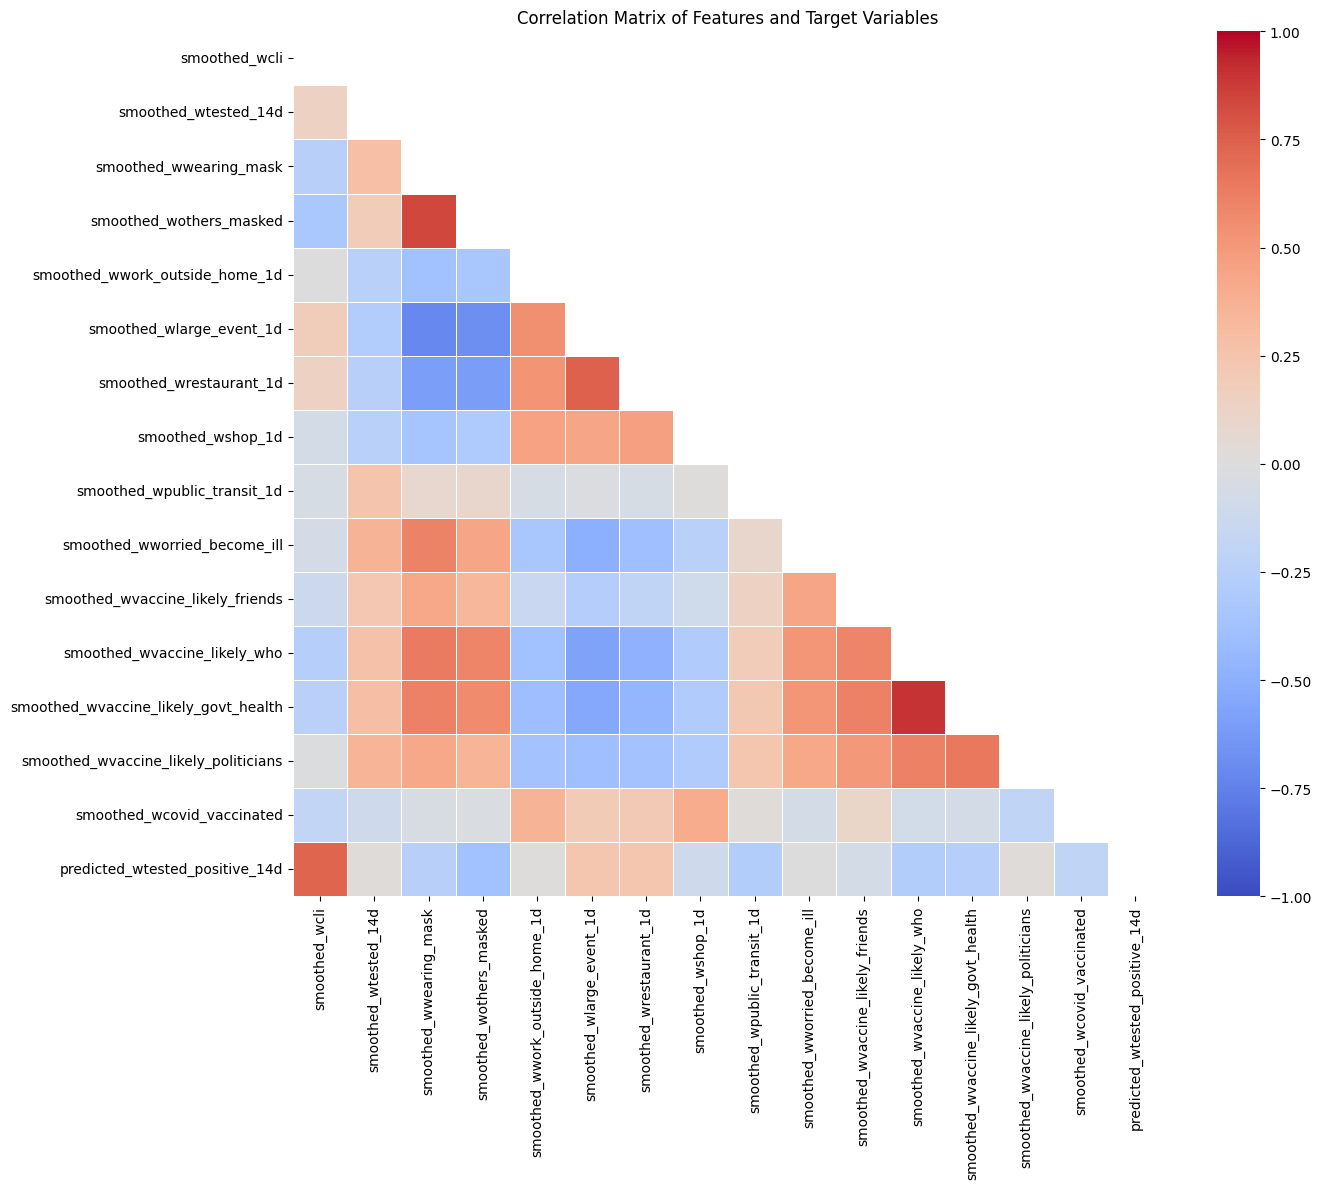

In [11]:
# 2. Feature Selection and Transformation
# Create correlation matrix to identify relationships
correlation_matrix = data[features + ['smoothed_wcovid_vaccinated', 'predicted_wtested_positive_14d']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Features and Target Variables')
plt.tight_layout()
plt.show()

In [12]:
# Identify highly correlated features (potential multicollinearity)
threshold = 0.8
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], 
                                   correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (r > 0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} and {feat2}: {corr:.4f}")


Highly correlated feature pairs (r > 0.8):
smoothed_wothers_masked and smoothed_wwearing_mask: 0.8385
smoothed_wvaccine_likely_govt_health and smoothed_wvaccine_likely_who: 0.9054


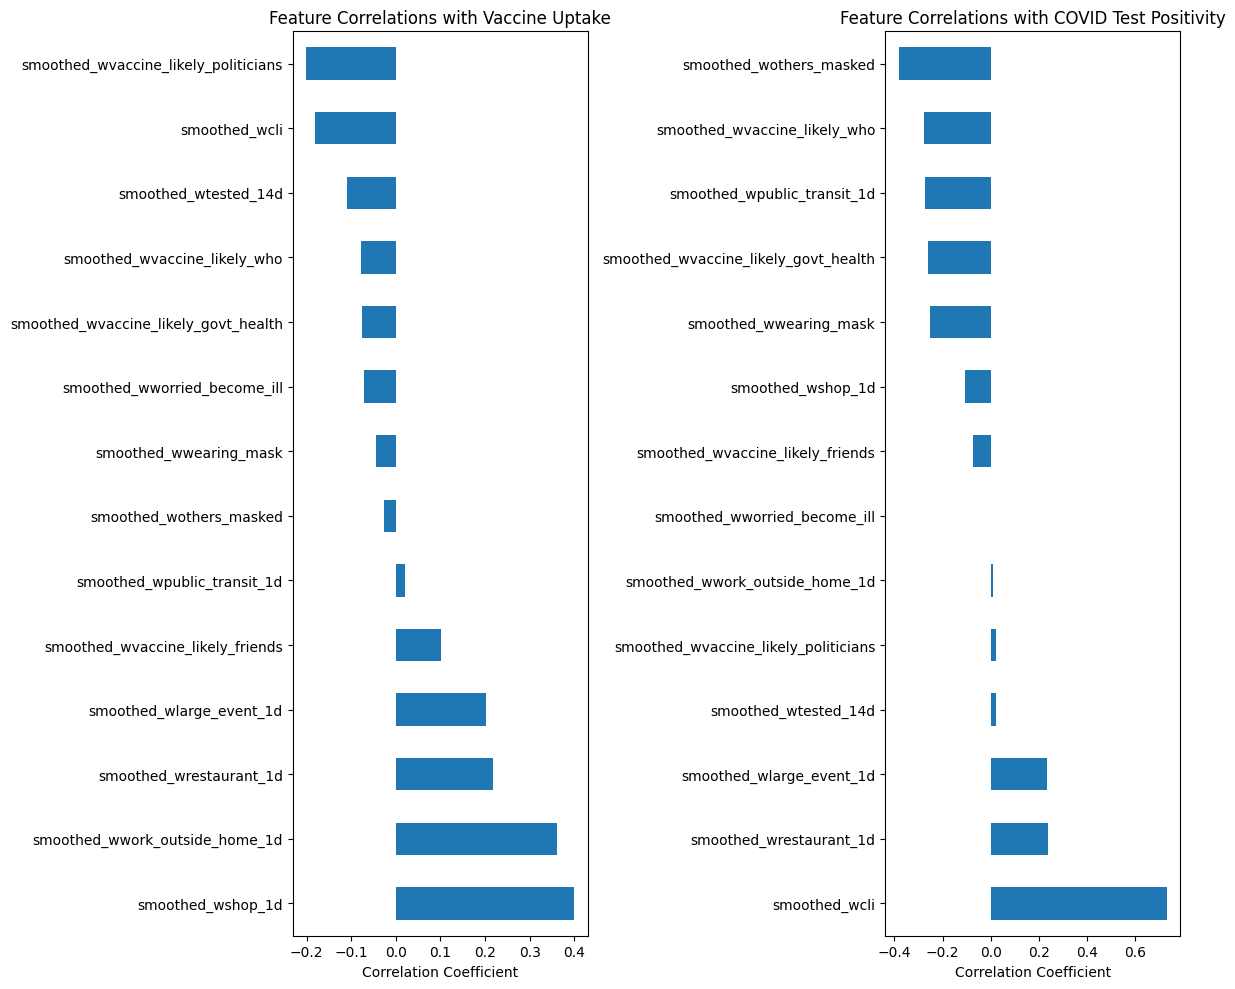


Feature Skewness:
smoothed_wcli                           0.973375
smoothed_wtested_14d                    0.934783
smoothed_wwearing_mask                 -1.253957
smoothed_wothers_masked                -1.261741
smoothed_wwork_outside_home_1d          0.186641
smoothed_wlarge_event_1d                0.760975
smoothed_wrestaurant_1d                 0.235473
smoothed_wshop_1d                       0.328400
smoothed_wpublic_transit_1d             5.409867
smoothed_wworried_become_ill           -0.306324
smoothed_wvaccine_likely_friends        0.078359
smoothed_wvaccine_likely_who            0.142068
smoothed_wvaccine_likely_govt_health    0.319968
smoothed_wvaccine_likely_politicians    0.569565
dtype: float64


In [13]:
# 3. Specifically examine correlations with target variables
target_correlations = correlation_matrix[['smoothed_wcovid_vaccinated', 'predicted_wtested_positive_14d']].drop(['smoothed_wcovid_vaccinated', 'predicted_wtested_positive_14d'])

# Sort and display correlations with targets
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
target_correlations['smoothed_wcovid_vaccinated'].sort_values(ascending=False).plot(kind='barh')
plt.title('Feature Correlations with Vaccine Uptake')
plt.xlabel('Correlation Coefficient')

plt.subplot(1, 2, 2)
target_correlations['predicted_wtested_positive_14d'].sort_values(ascending=False).plot(kind='barh')
plt.title('Feature Correlations with COVID Test Positivity')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Check for skewness in features and consider transformations
skewness = data[features].skew()
print("\nFeature Skewness:")
print(skewness)


Applying log transformation to 3 skewed features


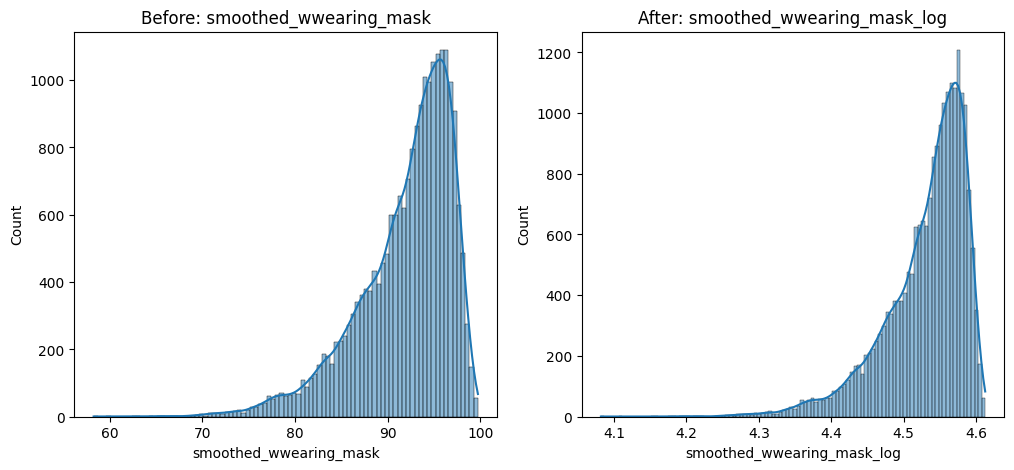

In [14]:
# Apply transformations to highly skewed features
skewed_features = skewness[abs(skewness) > 1].index
if len(skewed_features) > 0:
    print(f"\nApplying log transformation to {len(skewed_features)} skewed features")
    for feature in skewed_features:
        # Add a small constant to handle zeros
        data[f"{feature}_log"] = np.log1p(data[feature])
        
    # Show before/after for one example skewed feature
    if len(skewed_features) > 0:
        example_feature = skewed_features[0]
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(data[example_feature], kde=True)
        plt.title(f"Before: {example_feature}")
        
        plt.subplot(1, 2, 2)
        sns.histplot(data[f"{example_feature}_log"], kde=True)
        plt.title(f"After: {example_feature}_log")
        plt.show()

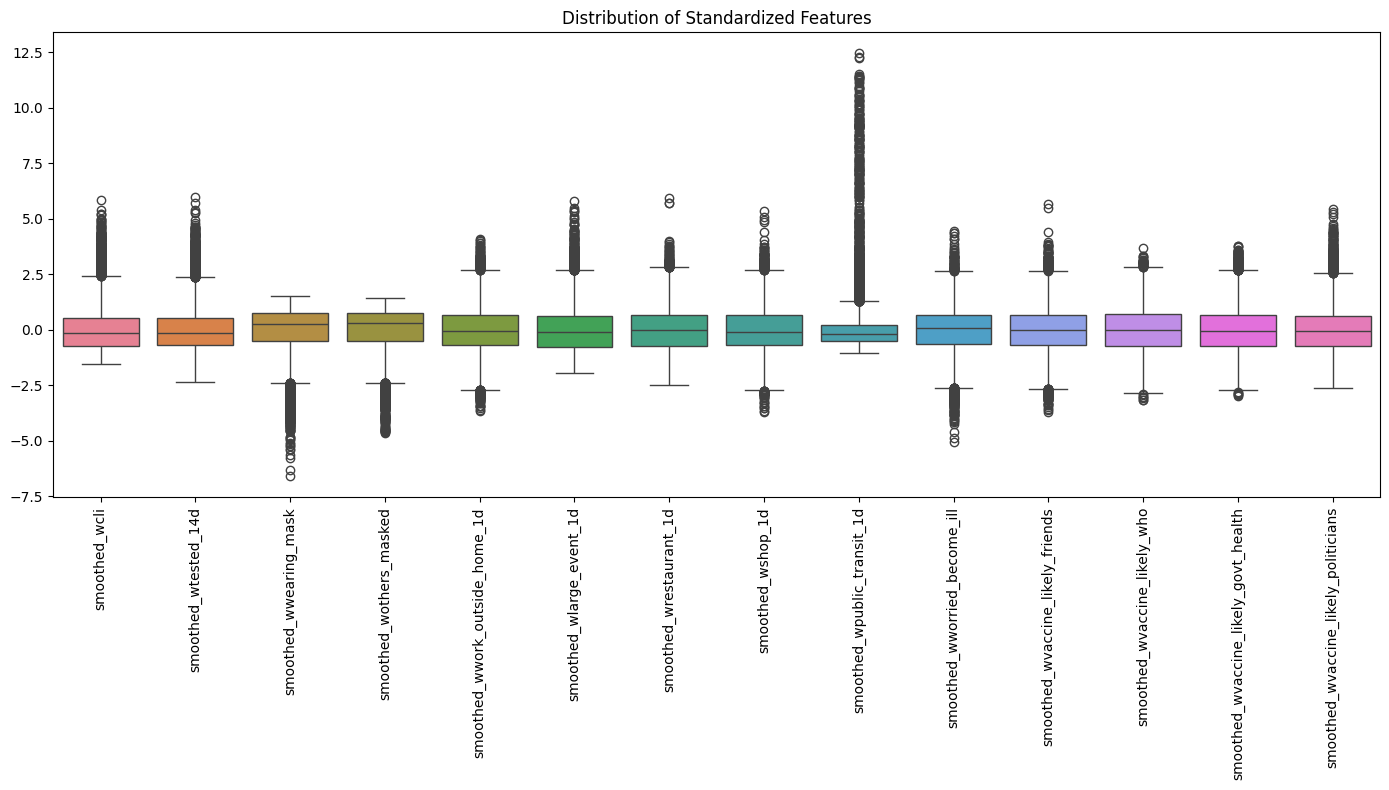

In [15]:
# Apply standardization to all features for modeling
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data[features]), 
    columns=features,
    index=data.index
)

# Show the distribution of scaled features
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_scaled)
plt.xticks(rotation=90)
plt.title('Distribution of Standardized Features')
plt.tight_layout()
plt.show()

In [16]:
# Summary statistics of the cleaned and transformed dataset
print("\nSummary Statistics after Cleaning and Transformation:")
print(data_scaled.describe())


Summary Statistics after Cleaning and Transformation:
       smoothed_wcli  smoothed_wtested_14d  smoothed_wwearing_mask  \
count   2.548100e+04          2.468800e+04            2.198500e+04   
mean    7.361692e-17          2.762966e-17            8.907236e-16   
std     1.000020e+00          1.000020e+00            1.000023e+00   
min    -1.518803e+00         -2.365291e+00           -6.591823e+00   
25%    -7.114788e-01         -6.960624e-01           -5.147636e-01   
50%    -1.619000e-01         -1.440933e-01            2.563232e-01   
75%     5.486911e-01          5.345306e-01            7.455543e-01   
max     5.855015e+00          6.002190e+00            1.532283e+00   

       smoothed_wothers_masked  smoothed_wwork_outside_home_1d  \
count             2.209700e+04                    2.506600e+04   
mean              5.505042e-16                   -1.179230e-16   
std               1.000023e+00                    1.000020e+00   
min              -4.627681e+00                   -

In [17]:
# Save processed dataset for Phase III
processed_data = data.copy()
# Add scaled features with proper column names
for feature in features:
    processed_data[f"{feature}_scaled"] = data_scaled[feature]

# Save the processed dataset
processed_data.to_csv('processed_covid_data.csv', index=False)

print("\nPhase II completed. Dataset cleaned, transformed, and saved for predictive modeling.")


Phase II completed. Dataset cleaned, transformed, and saved for predictive modeling.


### Phase III: Predictive Modeling

In [ ]:
# Load the processed data
try:
    processed_data = pd.read_csv('processed_covid_data.csv')
except:
    processed_data = data.copy()  # Use existing if file not found

# Define prediction targets
# For vaccine uptake: use the original target as it has fewer missing values
# For COVID positivity: use our semi-supervised generated target
targets = {
    'vaccine_uptake': 'smoothed_wcovid_vaccinated',
    'covid_positivity': 'predicted_wtested_positive_14d'
}

#### 1. Import Libraries

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Define the neural network architecture

In [37]:
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim):
        super(SimpleRegressor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

# Train function
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluate function
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            y_true.append(targets.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    
    # Calculate average loss
    avg_loss = total_loss / len(loader)

    # Flatten the lists
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return avg_loss, mse, mae, r2

# PyTorch Training Loop
def run_torch_training(data, features, targets, num_epochs=25, batch_size=64, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    all_results = {}

    for target_name, target_col in targets.items():
        print(f"\n--- Training PyTorch NN for: {target_name} ---")
        
        # Prepare data
        X = data[features].values
        y = data[target_col].values
        mask = ~np.isnan(y)
        X, y = X[mask], y[mask]

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

        # Dataloaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

        # Model, loss, optimizer
        model = SimpleRegressor(input_dim=X.shape[1]).to(device)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, test_losses = [], []

        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
            test_loss, mse, mae, r2 = evaluate(model, test_loader, loss_fn, device)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Store results
        all_results[target_name] = {
            'train_losses': train_losses, 
            'test_losses': test_losses}
        
        # Calculate final metrics
        final_test_loss, mse, mae, r2 = evaluate(model, test_loader, loss_fn, device)
        all_results[target_name].update({
            'MSE': mse,
            'MAE': mae,
            'R²': r2
        })
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title(f'Training & Test Loss - {target_name.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return all_results


--- Training PyTorch NN for: vaccine_uptake ---
Epoch 5/25 - Train Loss: 44.1922, Test Loss: 45.5453
Epoch 10/25 - Train Loss: 44.1653, Test Loss: 45.5435
Epoch 15/25 - Train Loss: 44.1664, Test Loss: 45.5436
Epoch 20/25 - Train Loss: 44.1669, Test Loss: 45.5377
Epoch 25/25 - Train Loss: 44.1516, Test Loss: 45.5640


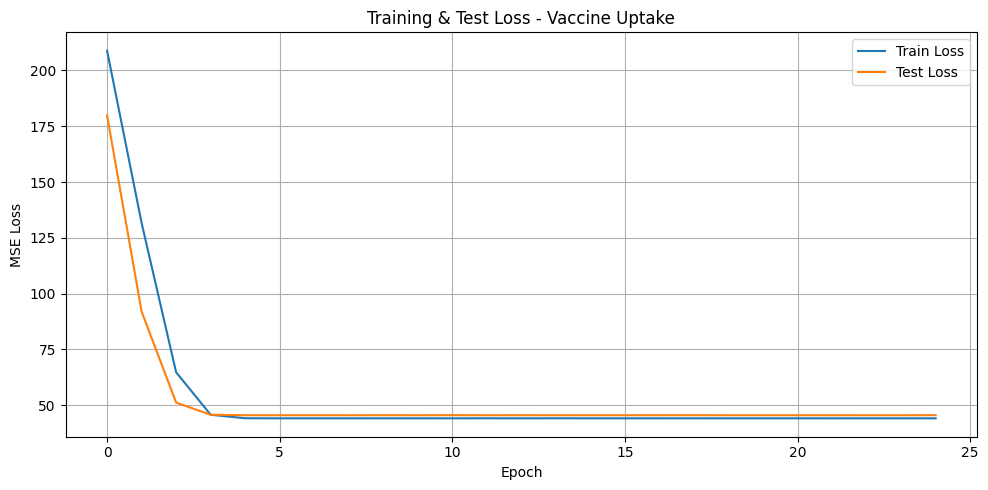


--- Training PyTorch NN for: covid_positivity ---
Epoch 5/25 - Train Loss: 33.2893, Test Loss: 33.1011
Epoch 10/25 - Train Loss: 33.2557, Test Loss: 33.1076
Epoch 15/25 - Train Loss: 33.3029, Test Loss: 33.1085
Epoch 20/25 - Train Loss: 33.2797, Test Loss: 33.1137
Epoch 25/25 - Train Loss: 33.3185, Test Loss: 33.1041


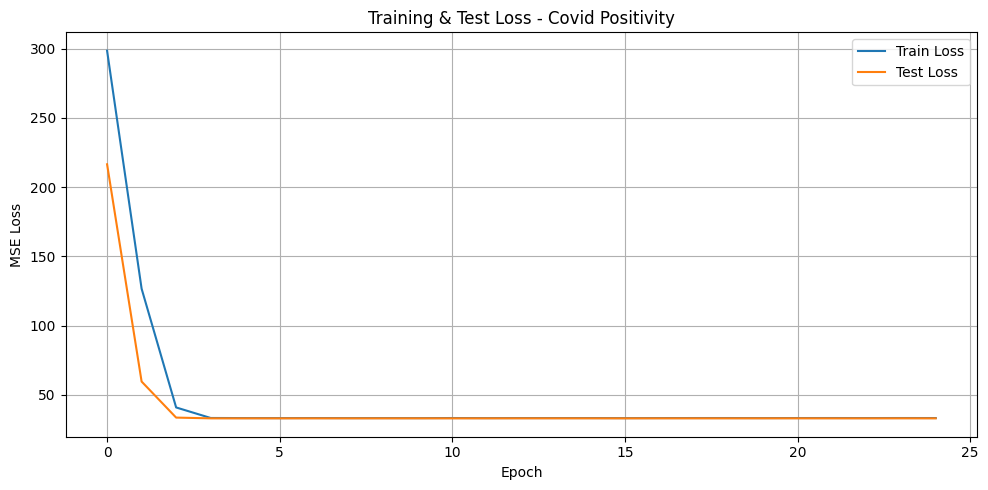

{'vaccine_uptake': {'train_losses': [208.85600826475354, 131.68461420800952, 64.77170112397935, 45.752200550503204, 44.19224656952752, 44.15825217299991, 44.161504374610054, 44.16181933879852, 44.14953066243066, 44.16529876656003, 44.160139640172325, 44.17358550098207, 44.15839660829968, 44.17619172069762, 44.16640502214432, 44.155192348692154, 44.165732403596245, 44.153031004799736, 44.163002563847435, 44.1669058005015, 44.16627121633954, 44.148176557487915, 44.163503766059875, 44.1590226954884, 44.1516216662195], 'test_losses': [179.87009048461914, 91.99252843856812, 51.19298089875115, 45.75647987259759, 45.54532927936978, 45.54121804237366, 45.54691423310174, 45.5371605820126, 45.55679538514879, 45.543475495444405, 45.57128935390048, 45.537499825159706, 45.552325831519234, 45.54009132915073, 45.54358294275072, 45.5449210802714, 45.55627708964877, 45.55654843648275, 45.5397309727139, 45.53774044248793, 45.54129036267599, 45.54387058152093, 45.53766793674893, 45.537302600012886, 45.56

In [38]:
# Define models with preprocessing pipelines
models = {
    'Ridge': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0, random_state=42))
    ]),
    'Lasso': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Fold Evaluation Function
def evaluate_models(X, y, models, cv):
    results = {}
    
    for name, model in models.items():
        # Metrics for each fold
        mse_scores = []
        mae_scores = []
        r2_scores = []
        
        print(f"\nEvaluating {name}...")
        
        # K-fold validation
        for train_idx, test_idx in cv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Handle missing values in y
            mask_train = ~np.isnan(y_train)
            mask_test = ~np.isnan(y_test)
            
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
            X_test = X_test[mask_test]
            y_test = y_test[mask_test]
            
            if len(y_train) == 0 or len(y_test) == 0:
                print(f"Skipping fold - insufficient data after removing NaN values")
                continue
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Store scores
            mse_scores.append(mse)
            mae_scores.append(mae)
            r2_scores.append(r2)
        
        if len(mse_scores) > 0:
            # Average scores across folds
            avg_mse = np.mean(mse_scores)
            std_mse = np.std(mse_scores)
            avg_mae = np.mean(mae_scores)
            std_mae = np.std(mae_scores)
            avg_r2 = np.mean(r2_scores)
            std_r2 = np.std(r2_scores)
            
            # Store results
            results[name] = {
                'MSE': f"{avg_mse:.4f} ± {std_mse:.4f}",
                'MAE': f"{avg_mae:.4f} ± {std_mae:.4f}",
                'R²': f"{avg_r2:.4f} ± {std_r2:.4f}",
                'model': model
            }
            
            print(f"  MSE: {avg_mse:.4f} ± {std_mse:.4f}")
            print(f"  MAE: {avg_mae:.4f} ± {std_mae:.4f}")
            print(f"  R²: {avg_r2:.4f} ± {std_r2:.4f}")
        
    return results

# Run predictions
all_results = {}

# Select features for modeling
model_features = features  # Using the features list we defined earlier

# Evaluate PyTorch model separately
pytorch_results = run_torch_training(processed_data, model_features, targets)

print(pytorch_results)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

for target_name, target_col in targets.items():
    print(f"\n--- Predicting {target_name} ---")
    
    # Prepare data
    X = processed_data[model_features].values
    y = processed_data[target_col].values
    
    # Evaluate standard models first (unchanged code)
    standard_models = {k: v for k, v in models.items() if k != 'NeuralNetwork'}
    target_results = evaluate_models(X, y, standard_models, cv)

    # Add PyTorch results to the target_results
    target_results.update({
        'PyTorch Neural Network': {
            'MSE': pytorch_results[target_name]['MSE'],
            'MAE': pytorch_results[target_name]['MAE'],
            'R²': pytorch_results[target_name]['R²']
        }
    })

    # Combine results
    all_results[target_name] = target_results
    
    # Prepare DataFrame for visualization
    results_df = pd.DataFrame({
        model_name: [results['MSE'], 
                    results['MAE'], 
                    results['R²']]
        for model_name, results in target_results.items() if 'MSE' in results
    }, index=['MSE', 'MAE', 'R²'])

    # Check the DataFrame contents
    print(results_df)

print("\nPredictive modeling completed")